In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import imgLoader as ld
from drawMap import drawMapGrid
from epipole import draw_epipolar_lines
import json
import math

%load_ext autoreload
%autoreload 2

OUTPUT_IMG_SIZE = [900, 450]

PLANET_RADIUS = 260
OM_RAD = 380.53
OM = [None, 
      [0, 0, +OM_RAD], 
      [0, 0, -OM_RAD], 
      [0, +OM_RAD, 0],
      [0, -OM_RAD, 0], 
      [+OM_RAD, 0, 0], 
      [-OM_RAD, 0, 0]]

PATH = "./images/"
PATH_PAIRS = "./pairs/"

# TEST: Compute Fundamental Matrix

In [2]:
img5, img5Meta = ld.readImg(PATH, "Cellin_5_cropped", "Cellin_5")
img6, img6Meta = ld.readImg(PATH, "Cellin_6_cropped", "Cellin_6")

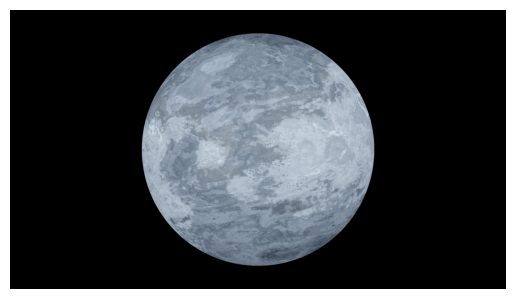

{
    "dim": [
        3840,
        2160
    ],
    "distance": {
        "om1": 593.7,
        "om2": null,
        "om3": 336.4,
        "om4": null,
        "om5": null,
        "om6": 310.2,
        "plt": 448.2
    },
    "fovU": 112,
    "planetName": "Cellin",
    "useCenter": [
        1920,
        1080
    ],
    "useRadius": 900
}


In [3]:
ld.showImg(img5)
ld.printMeta(img5Meta)

In [4]:
f = open(PATH_PAIRS + "5_6" + ".json")
pairs_5_6 = json.load(f)

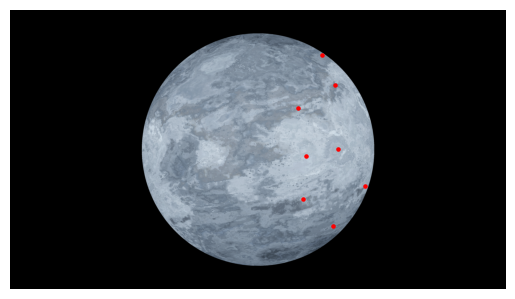

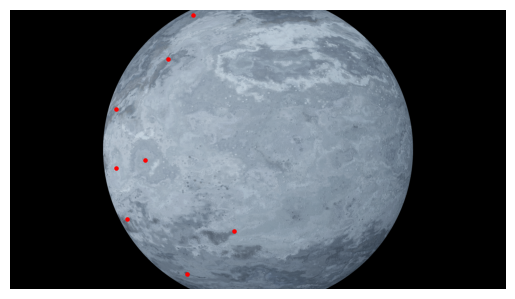

In [5]:
pt_5 = np.array(pairs_5_6["pt_5"])
pt_6 = np.array(pairs_5_6["pt_6"])
ld.showImgWithPts(img5, pt_5)
ld.showImgWithPts(img6, pt_6)

[[-1.27071347e-08  3.99275435e-07 -4.52788169e-04]
 [ 1.94558422e-07 -5.00397266e-08  8.32787336e-04]
 [-1.57367429e-04 -1.62308341e-03  1.00000000e+00]]


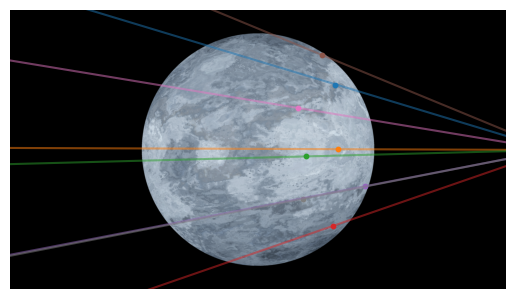

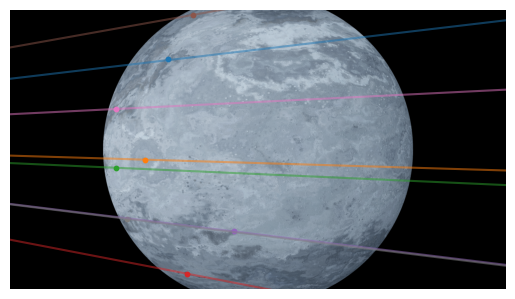

In [6]:
F65, mask = cv.findFundamentalMat(pt_5, pt_6, cv.FM_LMEDS)
F56 = F65.T
print(F56)

l = draw_epipolar_lines(img5, pt_6, pt_5, F56.T)
l = draw_epipolar_lines(img6, pt_5, pt_6, F56)

# TEST: Compute Essential Matrix

$$E = K_l^T F K_r$$

In [7]:
def computeK(maxU, maxV, fovU):
    # Compute Focal Length
    f = maxU / 2 / math.tan(math.radians(fovU / 2))
    
    K = np.array([[f,  0, maxU / 2],
                  [ 0, f, maxV / 2],
                  [ 0,  0,       1]])
    
    return K

In [8]:
# Computer Focal Length
K5 = computeK(img5.shape[1], img5.shape[0], img5Meta["fovU"])
K6 = computeK(img6.shape[1], img6.shape[0], img6Meta["fovU"])

E = K5.T @ F56 @ K6


In [9]:
print(E)

[[-0.02131204  0.66965316 -0.05953166]
 [ 0.32630773 -0.08392518  1.49228903]
 [ 0.03672517 -1.17917145  0.10114546]]


In [10]:
# Method from Hartley & Zisserman's book
U, S, Vt = np.linalg.svd(E)
W = np.array([[ 0, -1,  0],
              [+1,  0,  0],
              [ 0,  0, +1]])
Z = np.array([[ 0, +1,  0],
              [-1,  0,  0],
              [ 0,  0,  0]])
t = U @ Z @ U.T
R = U @ np.linalg.inv(W) @ Vt

print("t =")
print(t)
print("R =")
print(R)

t =
[[ 0.          0.49375883 -0.0012244 ]
 [-0.49375883  0.          0.86959802]
 [ 0.0012244  -0.86959802  0.        ]]
R =
[[-0.74454144 -0.00270351  0.66757077]
 [ 0.01362264 -0.9998451   0.01114418]
 [-0.66743724 -0.01739138 -0.74446294]]


In [11]:
t_x = t[2, 1]
t_y = t[0, 2]
t_z = t[1, 0]

t_norm = np.array([t_x, t_y, t_z]) / np.linalg.norm(np.array([t_x, t_y, t_z]))

### Validate the value

In [12]:
location5 = np.array([-327.78267271962784, 305.52303484613566, -8.926193861193727])
location6 = np.array(OM[6])

trans56 = location6 - location5
trans56_norm = trans56 / np.linalg.norm(trans56)

In [13]:
print("Computed: \n", t_norm)
print("Actual\n", trans56_norm)

Computed: 
 [-0.86959802 -0.0012244  -0.49375883]
Actual
 [-0.17005866 -0.98501364  0.02877826]


In [14]:
R_rough_Z = math.degrees(math.asin(R[0, 2]))

R_rough_actual = math.degrees(math.atan(location5[1] / -location5[0]))

In [15]:
print("Computed: \n", R_rough_Z)
print("Actual\n", R_rough_actual)

Computed: 
 41.879851451097885
Actual
 42.986977738610896


# Strategy

1. Find correspondence points pair between input image and an "anchor" image.
2. Calculate Fundamental Matrix $F$.
3. Calculate Essential Matrix $E$ with known focal length, known principal points, and $F$.
4. Calculate Rotation Matrix $R$ from $E$.
5. Calculate the rotation of the input image.
6. Project the input image to the Equirectangular map.

# Input Images

Use img #6 as the anchor, i.e. Location and Rotation are known. Then other images can use it as a reference to compute absolute Rotations from relative rotation matrices.

Use quadrilateral method to compute the location of each camera.

Img #6, pos = [-380.53, 0, 0]


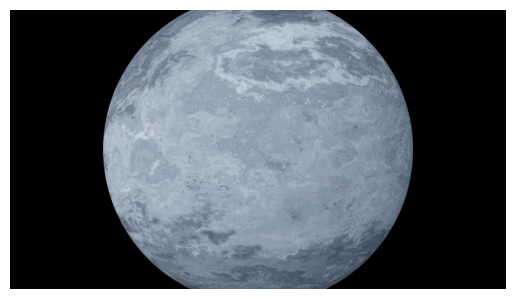

Img #7, pos = (-326.94606325388276, -191.76827175255568, 154.50014571781463)


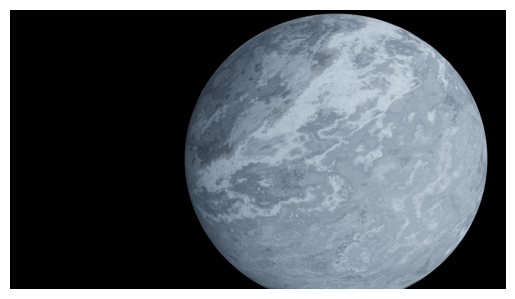

Img #8, pos = (-345.3813245999001, -178.88249402149634, -168.1618257430427)


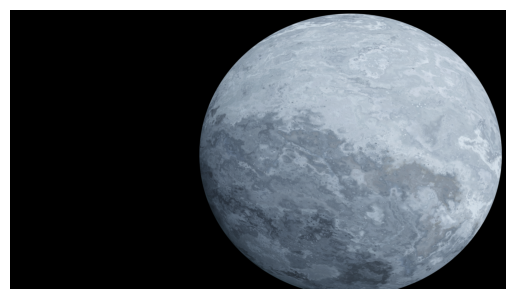

In [16]:
from quadrilateral import quadrilateral

IMG_DIM_U = 1920
IMG_DIM_V = 1080

img6, img6Meta = ld.readImg(PATH, "Cellin_6_c_half", "Cellin_6")
img7, img7Meta = ld.readImg(PATH, "Cellin_7_c", "Cellin_7")
img8, img8Meta = ld.readImg(PATH, "Cellin_8_c", "Cellin_8")
cam6pos = OM[6]
cam6dir = [1, 0, 0] # Pointing to X+
cam6up = [0, 0, 1]  # Pointing to Z+
cam7pos = quadrilateral(
    [0, 0, 0], img7Meta["distance"]["plt"], 
    OM[1], img7Meta["distance"]["om1"], 
    OM[4], img7Meta["distance"]["om4"], 
    OM[6], img7Meta["distance"]["om6"])
cam8pos = quadrilateral(
    [0, 0, 0], img8Meta["distance"]["plt"], 
    OM[1], img8Meta["distance"]["om1"], 
    OM[4], img8Meta["distance"]["om4"], 
    OM[6], img8Meta["distance"]["om6"])

print("Img #6, pos =", cam6pos)
ld.showImg(img6)
print("Img #7, pos =", cam7pos)
ld.showImg(img7)
print("Img #8, pos =", cam8pos)
ld.showImg(img8)

Place camera #7 and camera #8 in a 3D model. The computed positions looks correct.  
https://www.geogebra.org/calculator/hrqzetby

Camera #6 is located at OM6, pointing to the x+.

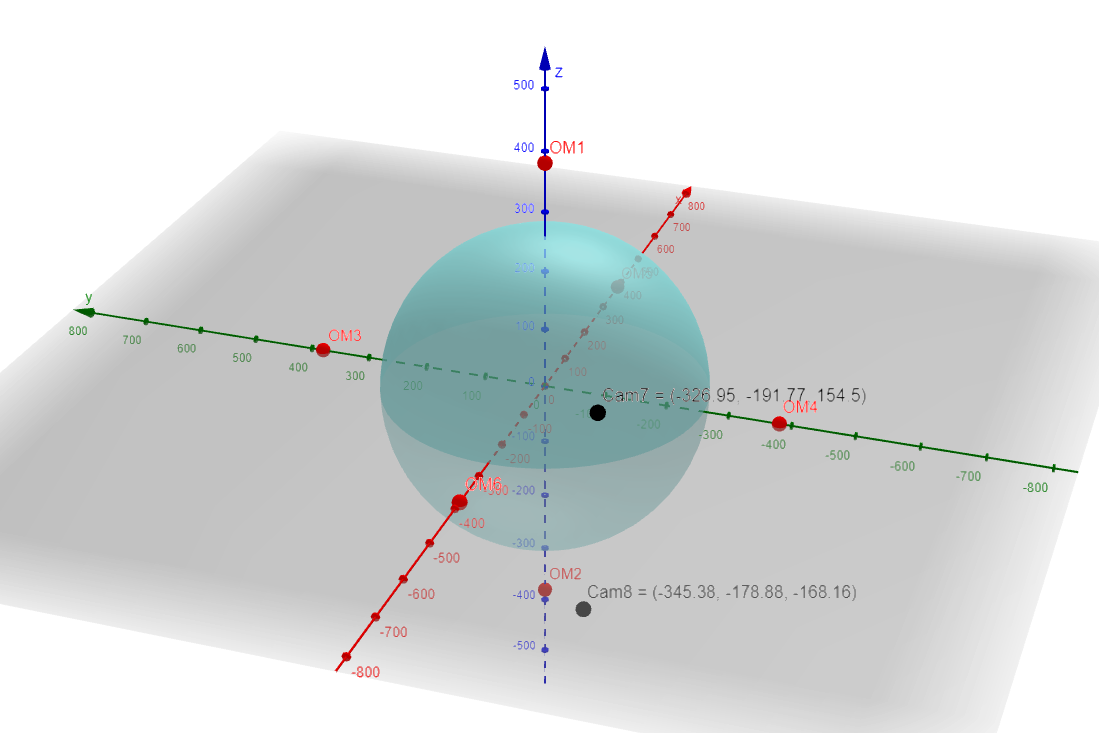
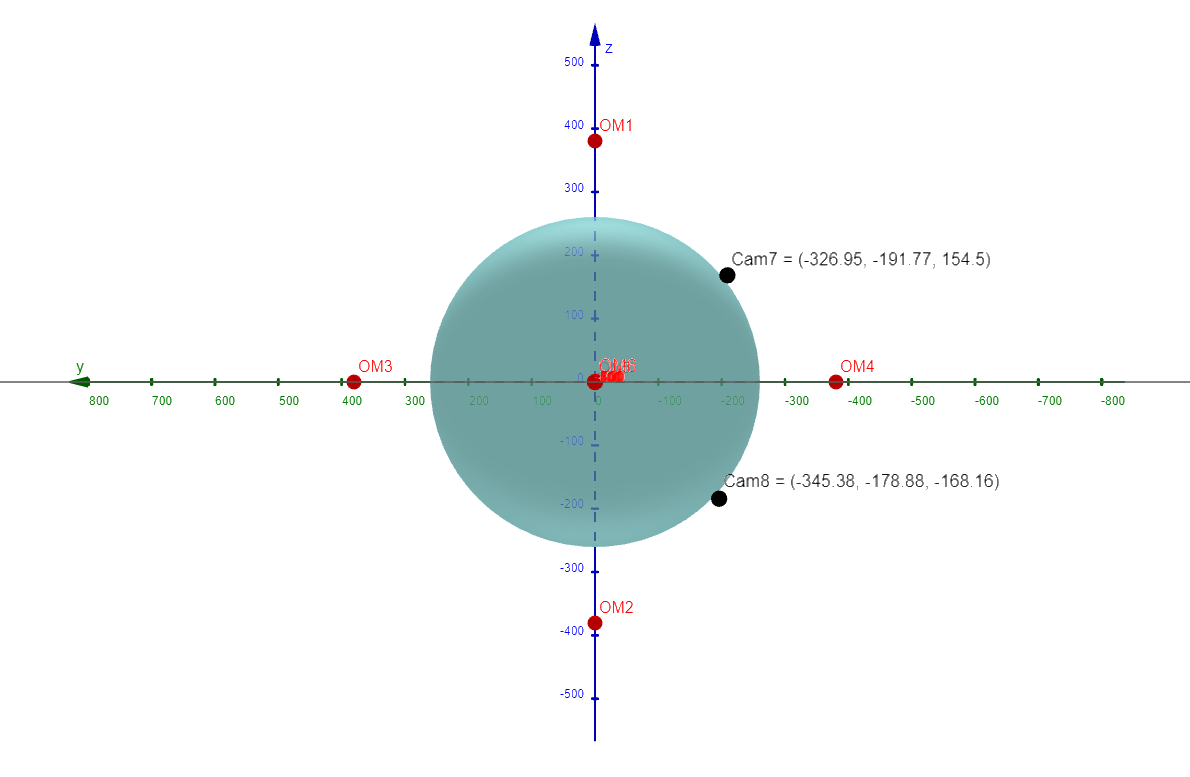

# Correspondence Pairs

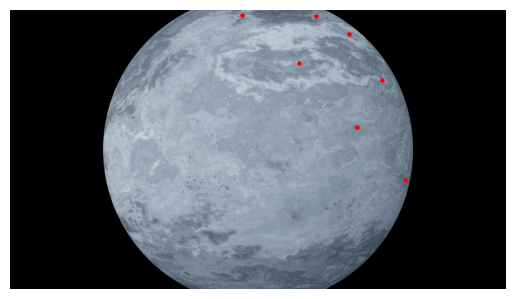

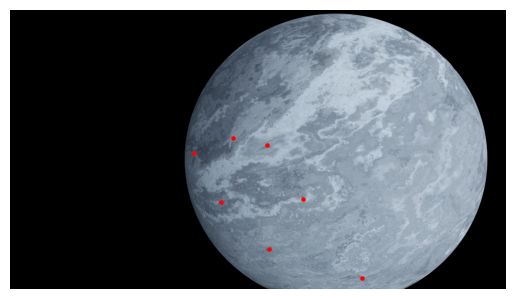

In [17]:
f = open(PATH_PAIRS + "6_7" + ".json")
p67 = json.load(f)

p67_6 = np.array(p67["6"])
p67_7 = np.array(p67["7"])
ld.showImgWithPts(img6, p67_6)
ld.showImgWithPts(img7, p67_7)

[[ 7.30729870e-07 -1.75844153e-07 -5.92377029e-05]
 [ 4.60223183e-07 -5.02407915e-07  5.11682249e-04]
 [-1.72670316e-03 -1.98036778e-04  1.00000000e+00]]


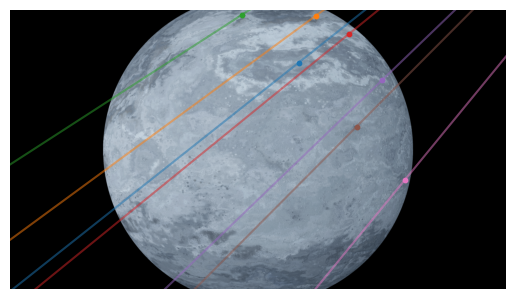

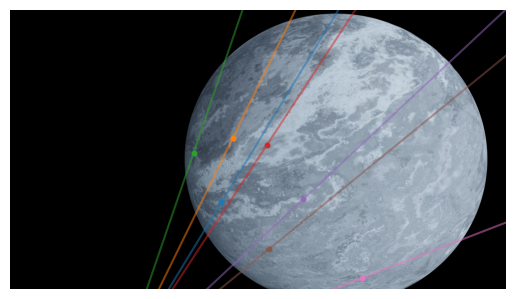

In [18]:
F76, mask = cv.findFundamentalMat(p67_6, p67_7, cv.FM_LMEDS)
F67 = F76.T
print(F67)

l = draw_epipolar_lines(img6, p67_7, p67_6, F76)
l = draw_epipolar_lines(img7, p67_6, p67_7, F67)

# Compute Essential Matrix

$$E = K_l^T F K_r$$

In [19]:
def computeK(maxU, maxV, fovU):
    # Compute Focal Length
    f = maxU / 2 / math.tan(math.radians(fovU / 2))
    
    K = np.array([[f,  0, maxU / 2],
                  [ 0, f, maxV / 2],
                  [ 0,  0,       1]])
    
    return K

In [20]:
K6 = computeK(img6.shape[1], img6.shape[0], img6Meta["fovU"])
K7 = computeK(img7.shape[1], img7.shape[0], img7Meta["fovU"])

E67 = K6.T @ F67 @ K7

# Compute Rotation Matrix

In [21]:
# Method from Hartley & Zisserman's book
U, S, Vt = np.linalg.svd(E67)
W = np.array([[ 0, -1,  0],
              [+1,  0,  0],
              [ 0,  0, +1]])
Z = np.array([[ 0, +1,  0],
              [-1,  0,  0],
              [ 0,  0,  0]])
t67 = U @ Z @ U.T
R67 = U @ np.linalg.inv(W) @ Vt

print("t =")
print(t67)
print("R =")
print(R67)

t =
[[ 0.          0.19919583  0.64802764]
 [-0.19919583  0.          0.73510625]
 [-0.64802764 -0.73510625  0.        ]]
R =
[[-0.75285789  0.06359852  0.65510322]
 [-0.33526611 -0.89356999 -0.29854532]
 [-0.56639354  0.44439611 -0.69405364]]


# Apply Rotation Matrix

In [22]:
cam7dir = [cam6dir[0], cam6dir[1], cam6dir[2]] @ R67
cam7up = [cam6up[0], cam6up[1], cam6up[2]] @ R67

print(cam7dir)
print(cam7up)

[-0.75285789  0.06359852  0.65510322]
[-0.56639354  0.44439611 -0.69405364]


# Project Input Image to Map

In [23]:
from longiLatiToImageUV import longiLatiToImageUV, projectToGround

## Map Anchor Image (as reference)

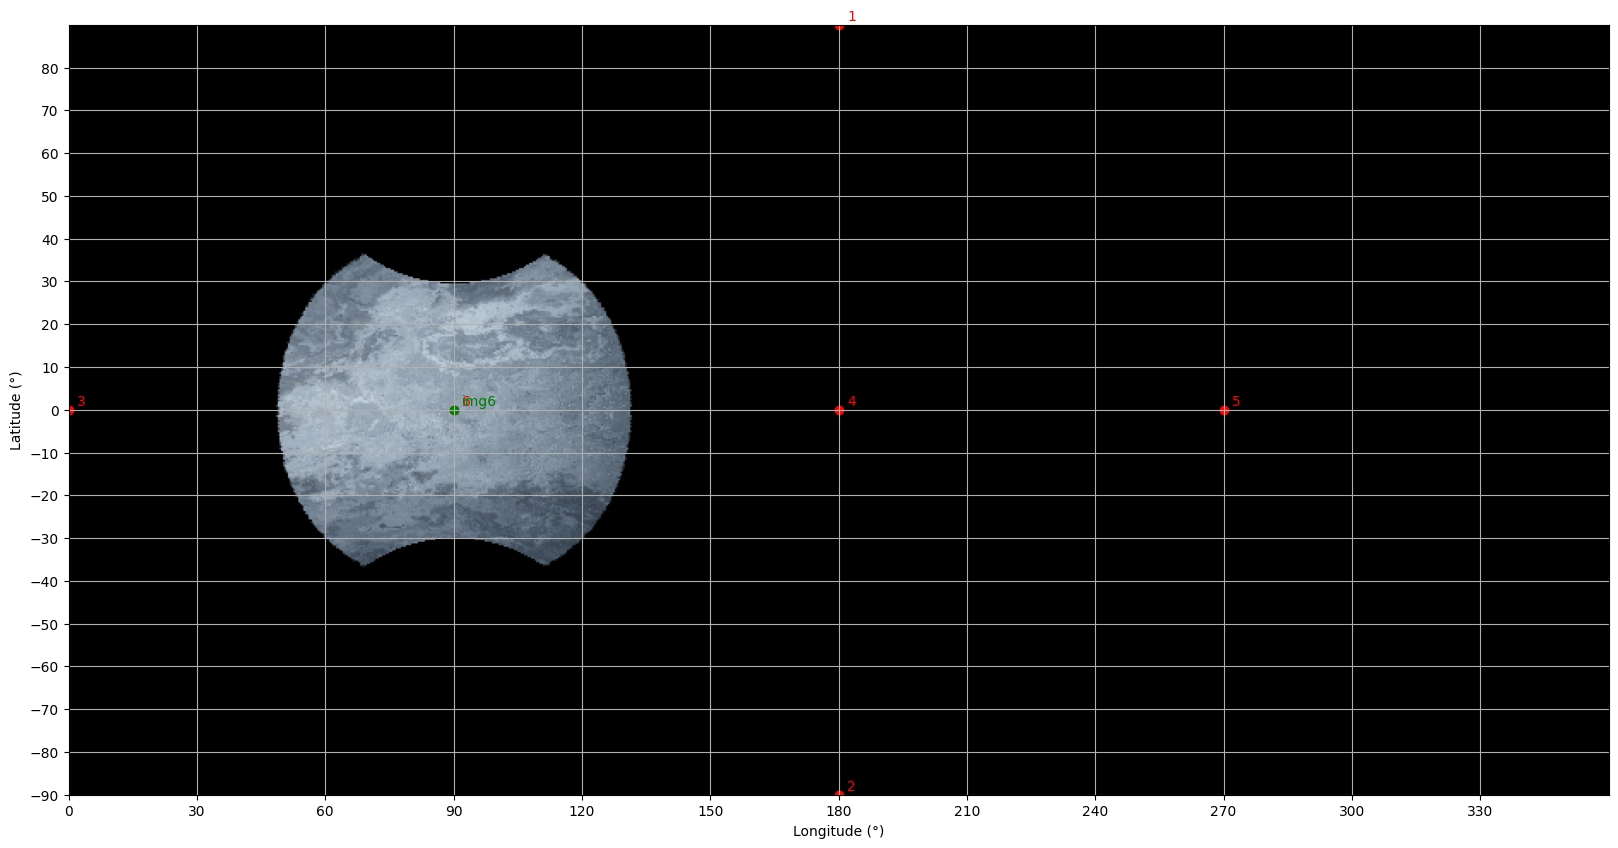

In [24]:
mapImg6 = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))

for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
        lo = u / OUTPUT_IMG_SIZE[0] * 360
        uInput, vInput = longiLatiToImageUV(PLANET_RADIUS, lo, la, IMG_DIM_U, IMG_DIM_V, img6Meta["fovU"], cam6pos, cam6dir, cam6up)
        if uInput is None or not (0 <= uInput < img6.shape[1] and 0 <= vInput < img6.shape[0]): 
            mapImg6[v, u] = [0, 0, 0]
            continue
        mapImg6[v, u] = img6[vInput, uInput]
        
drawMapGrid(mapImg6, [[90, 0]], ["img6"])

The projection of anchor image looks correct.

### BONUS: Test if the projection are correct

Test if the projection are correct using img #7 Referennce.
Shot directly to the center and up-direction is OM1.

In [37]:
img7_r, img7Meta = ld.readImg(PATH, "Cellin_7_reference_c", "Cellin_7")

mapImg7_r = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))

for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
        lo = u / OUTPUT_IMG_SIZE[0] * 360
        uInput, vInput = longiLatiToImageUV(PLANET_RADIUS, lo, la, IMG_DIM_U, IMG_DIM_V, img7Meta["fovU"], cam7pos, -np.array(cam7pos), (48.67, 28.55, 138.42))
        if uInput is None or not (0 <= uInput < img7_r.shape[1] and 0 <= vInput < img7_r.shape[0]): 
            mapImg7_r[v, u] = [0, 0, 0]
            continue
        mapImg7_r[v, u] = img7_r[vInput, uInput]

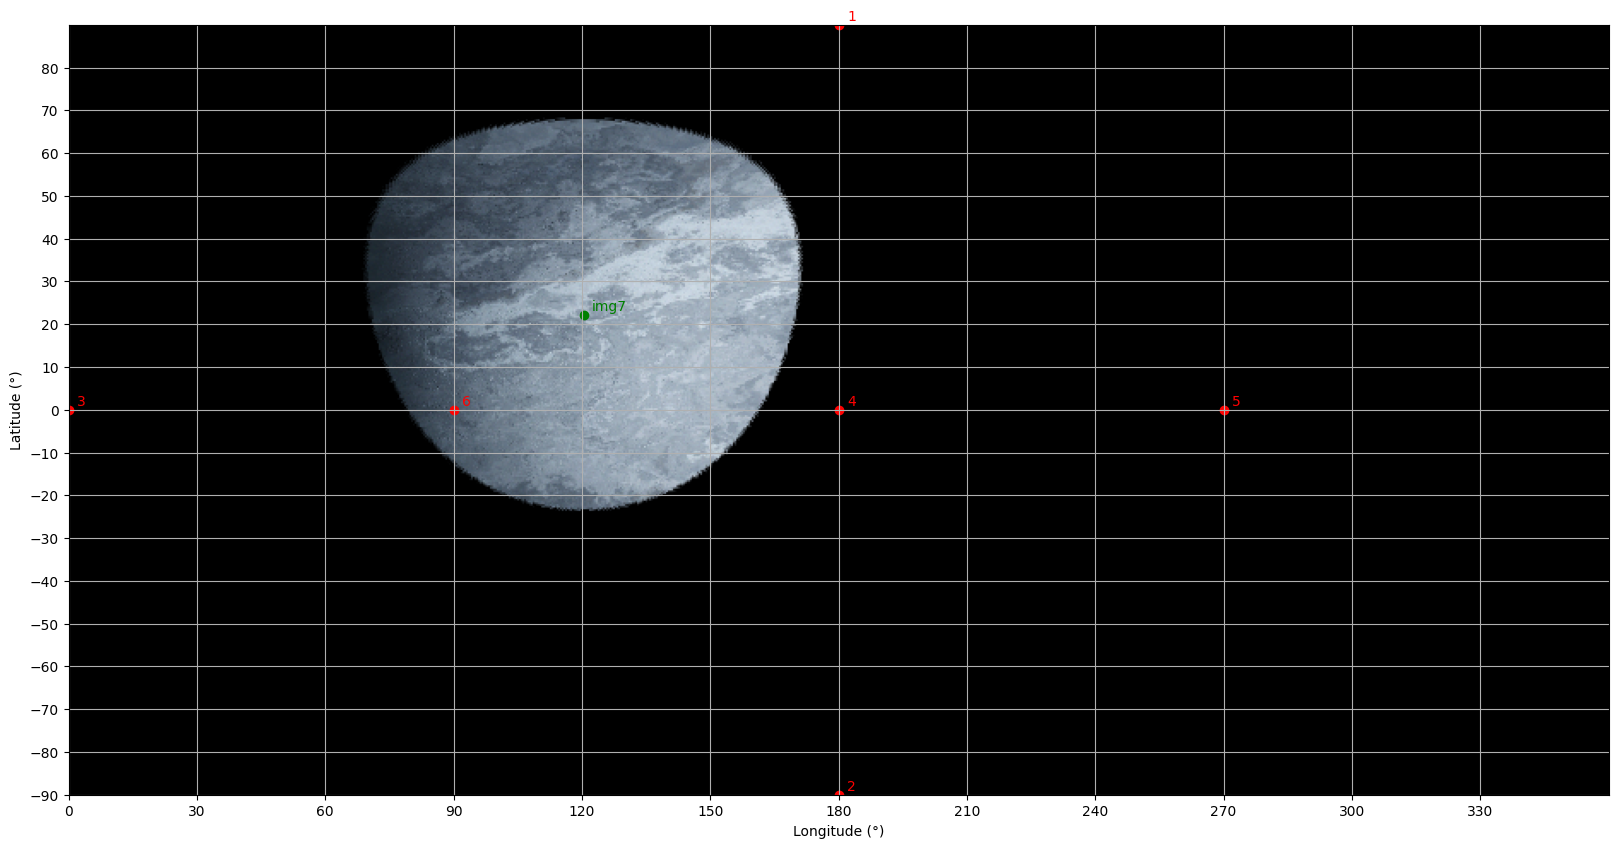

In [38]:
drawMapGrid(mapImg7_r, [projectToGround(cam7pos)], ["img7"])

The result is roughly correct. This can be use as a standard for the following projection of img #7.

## Map Other Image

In [25]:
mapImg7 = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))

for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
        lo = u / OUTPUT_IMG_SIZE[0] * 360
        uInput, vInput = longiLatiToImageUV(PLANET_RADIUS, lo, la, IMG_DIM_U, IMG_DIM_V, img7Meta["fovU"], cam7pos, cam7dir, cam7up)
        if uInput is None or not (0 <= uInput < img7.shape[1] and 0 <= vInput < img7.shape[0]): 
            mapImg7[v, u] = [0, 0, 0]
            continue
        mapImg7[v, u] = img7[vInput, uInput]

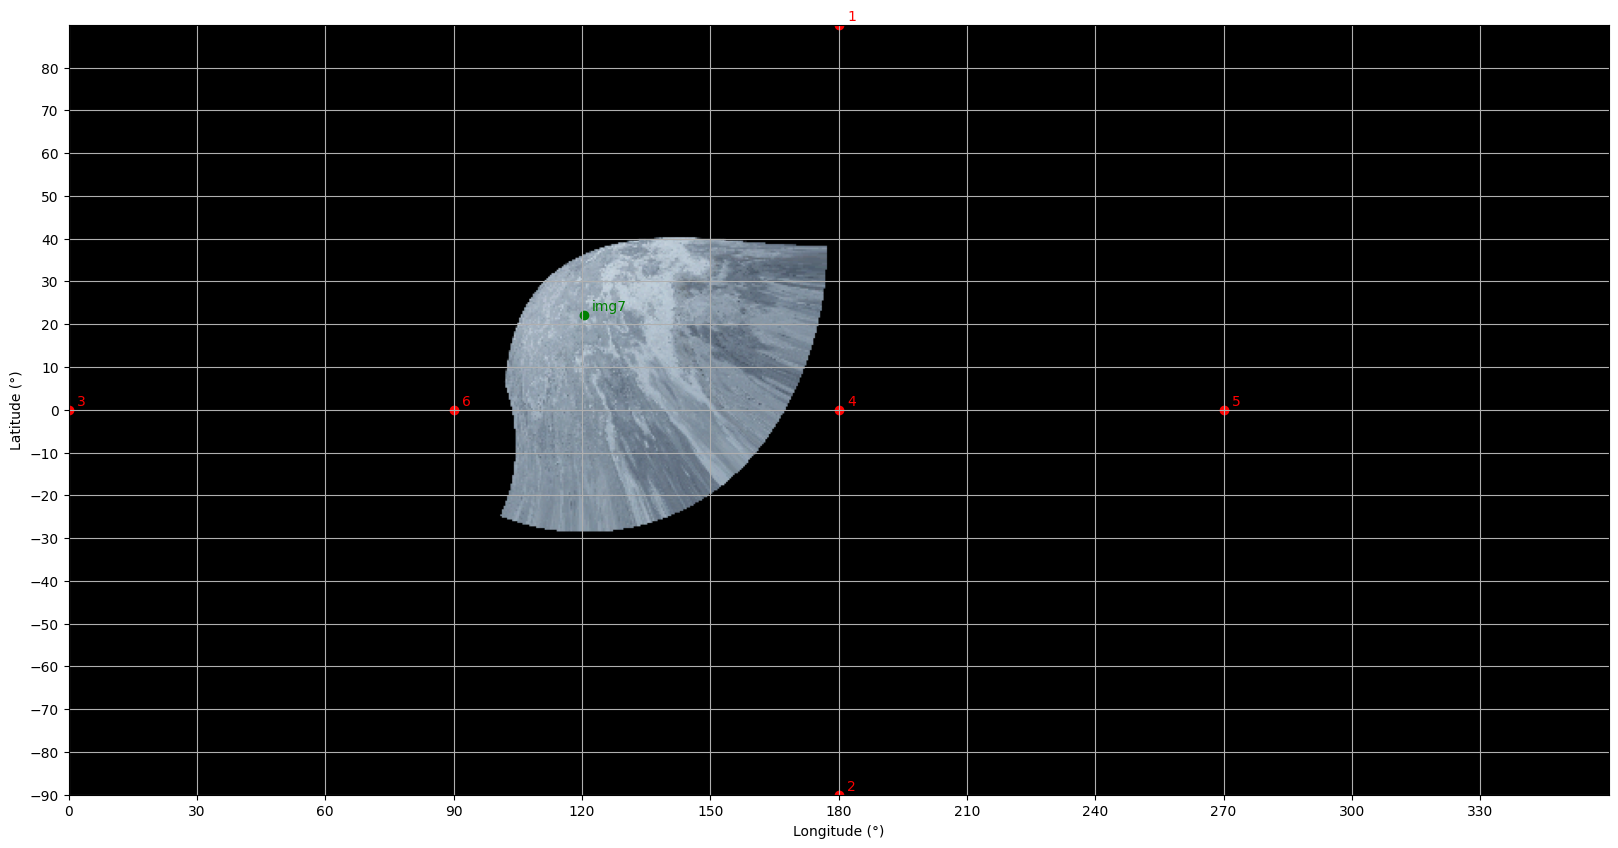

In [26]:
drawMapGrid(mapImg7, [projectToGround(cam7pos)], ["img7"])

Seems not correct. try using known translation.  
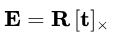

In [27]:
t67 = np.array(cam7pos) - np.array(cam6pos)

t67_sym = np.array([[0      ,  -t67[2], +t67[1]],
                    [+t67[2],       0, -t67[0]],
                    [-t67[1], +t67[0],       0]])

R67_new = E67 @ -t67_sym.T

print(R67_new)

[[ 56.57073652 -28.34728268 -54.80507566]
 [ 52.16558067  -6.1433842  -25.7174084 ]
 [-39.06087944  84.62618052 118.58663299]]


In [28]:
cam7dir_new = [cam6dir[0], cam6dir[1], cam6dir[2]] @ R67_new
cam7up_new = [cam6up[0], cam6up[1], cam6up[2]] @ R67_new

print(cam7dir_new)
print(cam7up_new)

[ 56.57073652 -28.34728268 -54.80507566]
[-39.06087944  84.62618052 118.58663299]


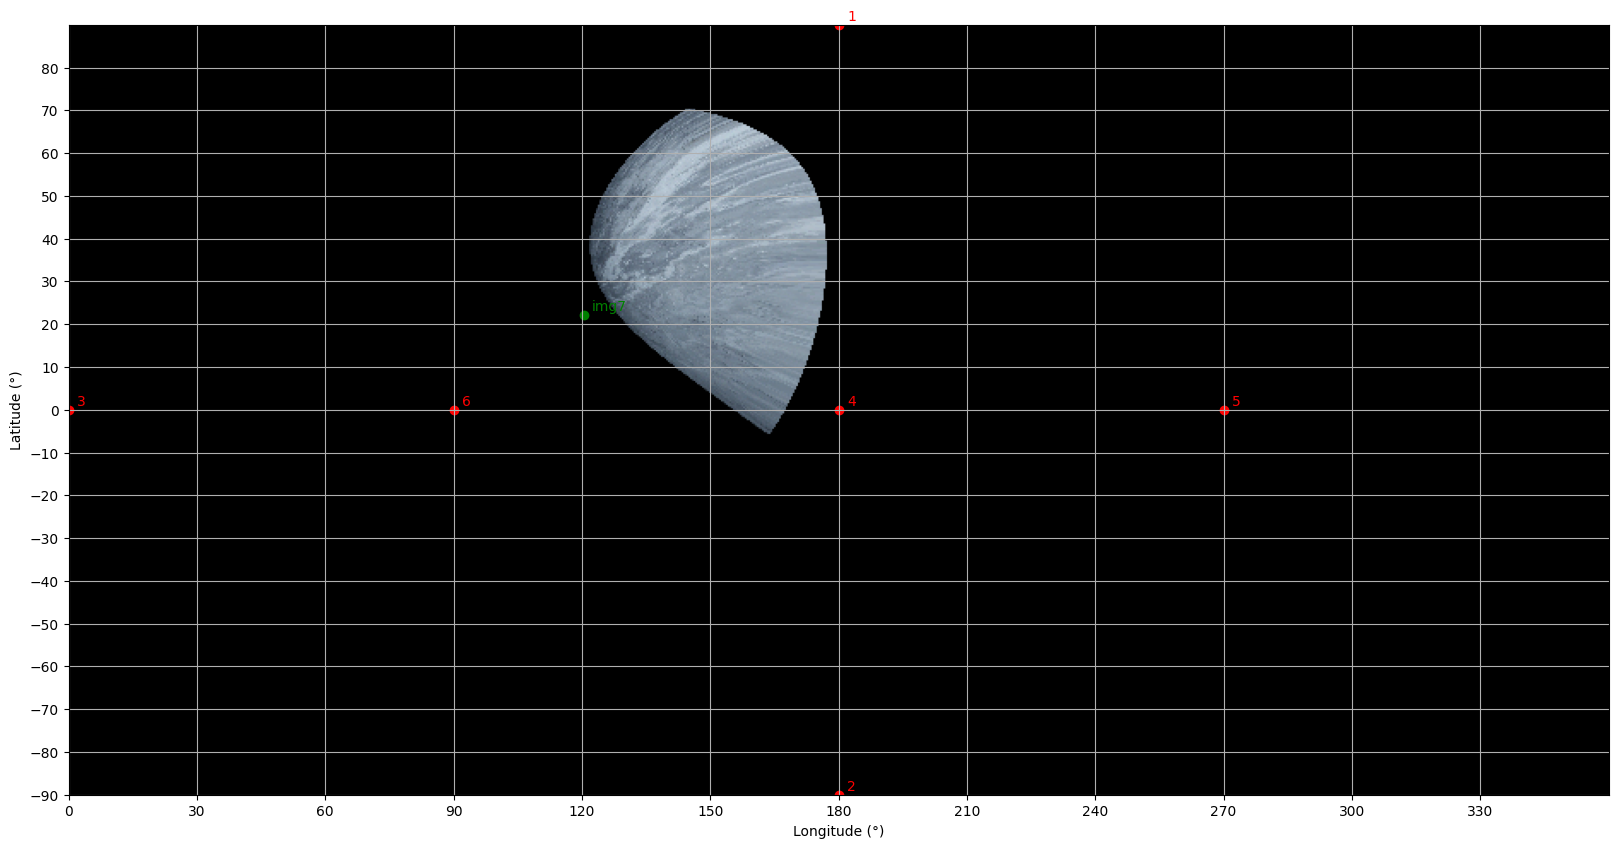

In [29]:
mapImg7_new = np.zeros((OUTPUT_IMG_SIZE[1], OUTPUT_IMG_SIZE[0], 3))

for v in range(OUTPUT_IMG_SIZE[1]):
    for u in range(OUTPUT_IMG_SIZE[0]):
        la = -v / OUTPUT_IMG_SIZE[1] * 180 + 90
        lo = u / OUTPUT_IMG_SIZE[0] * 360
        uInput, vInput = longiLatiToImageUV(PLANET_RADIUS, lo, la, IMG_DIM_U, IMG_DIM_V, img7Meta["fovU"], cam7pos, cam7dir_new, cam7up_new)
        if uInput is None or not (0 <= uInput < img7.shape[1] and 0 <= vInput < img7.shape[0]): 
            mapImg7_new[v, u] = [0, 0, 0]
            continue
        mapImg7_new[v, u] = img7[vInput, uInput]
drawMapGrid(mapImg7_new, [projectToGround(cam7pos)], ["img7"])

Still not satisfying. Is essential matrix accurate?